# 2D DDW
## Pedicting Crop Type from data based in India



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
import json

### **Model Outline(stuff yall can follow):**
> **Warning:** DO NOT MANIPULATE THE CSV FILES DIRECTLY. Any manipulation will be done by loading the data into a variable in your code. CSV FILES SHOULD BE UNTOUCHED. However you can create and export new CSV Files based on original data.


#### Step 1 Data Preprocessing:

**CSV Files**
```bash
├── Fertilizer.csv
├── Crop_Yield.csv
```
- Use charts to visualize, summarize and understand your data. Whatever stuff you guys can think of that will help someone to understand the data better(I'll do this~Gangesh)
- Display both files using pandas and take a look at the columns. You need to find a way to combine this datasets and remove some of the unnecessary columns(ex. Production column in final dataset. Crops which are not meant for consumptions like cotton,jute etc). 
- **Note:** Some of the crop names in the soil conditions file and the Crop Yield file dont match exactly. Find a way to accurately still combine the datasets.
- After which, recall what i said about data that are not numbers, in this case states. Look up panda dummy variables.
- Normalize the data. Can use the one in problems set.
  
#### Step 2 Training and Validation:
- Follow the initial steps exactly as in cohort 9 to train your first model
- evaluate the model using an appropriate metric. Indicate all data of the trained model together with the error through your chosen error function. Visualize the trained model/training of the model with maybe types of graph
- Take steps to improve your model. Try to search online. One way is to vary the iterations and learning rate. Train a few times, then choose the model with the best accuracy.

#### Step 3 Prediction:
- Find a way to predict the crop type that gives the highest yield. 
- Recall that the above model predicts highest yield for any given crop type. So what you would do is create a function where the user types in everything except for crop, and you would go on to predict yield for every crop with the inputted variables. After which you will choose the crop with the highest yield and return it 
- In the crop yield csv you will notice a crop_type column. This refers the the type of seasonal crop they are. Ex. Rabi Crops are harvested in the spring season while it is sown in winter. Create a function where if i input a date, I can receive the corresponding crop type.


### Date  Pre-processing

In [252]:
df_TempCropYield = pd.read_csv("Crop_Yield.csv")
df_CropSoilConditions = pd.read_csv("Crop_Ideal_Soil_Conditions.csv")
#add soil condition columns to start combining
df_TempCropYield['N'] = 0
df_TempCropYield['P'] = 0
df_TempCropYield['K'] = 0
df_TempCropYield['pH'] = 0

# string1 = "Ragi( naachnnii)"
# string2 = "Ragi"
# str1 = "Chili"
# str2 = "Dry chillies"
# # Calculate the similarity score using fuzz.ratio
# score1 = fuzz.partial_ratio(string1,string2)
# score2 = fuzz.partial_ratio(str1,str2)
# print(score1)
# print(score2)
# Using partial_ratio returned the best comparison result on sample set

# Delete rows with cotton or jute in the 'Crop' column as those are not edible
values_to_delete = ['Cotton(lint)', 'Jute','Jute & mesta']
df_TempCropYield = df_TempCropYield[~df_TempCropYield['Crop'].isin(values_to_delete)]
# Mapping dictionary for crop name conversion to assist in combining datasets
crop_mapping = {
    'Arhar/Tur': 'Pigeon peas(Toor Dal)',
    'Moong(Green Gram)': 'Mung beans',
    'Urad': 'Black Gram',
    'Sesamum': 'Sesame Seed',
    'Bhindi': 'Lady Finger',
    'Cowpea(Lobia)': 'Black eyed beans(Chawli)',
    'Guar seed': 'Cluster Beans(Gavar)'
}
# Replace crop names in the 'Crop' column
df_TempCropYield['Crop'] = df_TempCropYield['Crop'].replace(crop_mapping)
display(df_TempCropYield)

for index, row in df_TempCropYield.iterrows():
    # Match the crop string using fuzzywuzzy
    match = process.extractOne(row['Crop'], df_CropSoilConditions['Crop'],scorer=fuzz.partial_ratio)
    
    # Randomly pick one of the matches
    matched_rows = df_CropSoilConditions[df_CropSoilConditions['Crop'] == match[0]]
    random_matched_row = matched_rows.sample(n=1)
    
    # Copy the values to df_TempCropYield if a match is found
    if match[1] >= 80:  # Replace YOUR_THRESHOLD with your desired matching threshold
        df_TempCropYield.at[index, 'N'] = random_matched_row['N'].values[0]
        df_TempCropYield.at[index, 'P'] = random_matched_row['P'].values[0]
        df_TempCropYield.at[index, 'K'] = random_matched_row['K'].values[0]
        df_TempCropYield.at[index, 'pH'] = pd.to_numeric(random_matched_row['pH'].values[0], errors='coerce')
    else:
        # Add NaN if no match is found
        df_TempCropYield.at[index, 'N'] = None
        df_TempCropYield.at[index, 'P'] = None
        df_TempCropYield.at[index, 'K'] = None
        df_TempCropYield.at[index, 'pH'] = None
#Drop crows for which soil data cant be found
df_TempCropYield = df_TempCropYield.dropna(subset=['N'])
#remove Outliers
columns_to_clean = ['Yield_ton_per_hec', 'rainfall', 'temperature', 'N', 'P', 'K', 'pH']

# Q1 = df_TempCropYield[columns_to_clean].quantile(0.25)
# Q3 = df_TempCropYield[columns_to_clean].quantile(0.75)
# IQR = Q3 - Q1

# df_TempCropYield = df_TempCropYield[~((df_TempCropYield[columns_to_clean] < (Q1 - 1.5 * IQR)) |(df_TempCropYield[columns_to_clean] > (Q3 + 1.5 * IQR))).any(axis=1)]
# Calculate mean and standard deviation
mean_values = df_TempCropYield[columns_to_clean].mean()
std_values = df_TempCropYield[columns_to_clean].std()

# Identify outliers using the 3 standard deviation method
outliers = (np.abs((df_TempCropYield[columns_to_clean] - mean_values) / std_values) > 3).any(axis=1)

# Remove outliers
df_TempCropYield = df_TempCropYield[~outliers]
df_TempCropYield = df_TempCropYield.dropna(subset=['N'])
# df_TempCropYield.to_csv('Crop_Yield_Combined_NoDummy_NoOutl_3STD.csv', index=False)
df_TempCropYield.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
#convert categories to dummy variables
df_TempCropYield_NoCat = pd.get_dummies(df_TempCropYield,dtype=int)
#move y column to last
df_TempCropYield_NoCat["Yield_ton_per_hec"] = df_TempCropYield_NoCat.pop("Yield_ton_per_hec")
# df_TempCropYield_NoCat.to_csv('Crop_Yield_Combined_NoOutl_3STD.csv', index=False)


,State_Name,Crop_Type,Crop,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec,N,P,K,pH
0,andhra pradesh,kharif,Pigeon peas(Toor Dal),654.34,29.266667,21400.0,2600.0,0.121495,0,0,0,0
1,andhra pradesh,kharif,Bajra,654.34,29.266667,1400.0,500.0,0.357143,0,0,0,0
2,andhra pradesh,kharif,Castor seed,654.34,29.266667,1000.0,100.0,0.100000,0,0,0,0
4,andhra pradesh,kharif,Dry chillies,654.34,29.266667,3700.0,7100.0,1.918919,0,0,0,0
5,andhra pradesh,kharif,Groundnut,654.34,29.266667,650800.0,228400.0,0.350953,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
173021,west bengal,summer,Maize,182.50,29.200000,258.0,391.0,1.515504,0,0,0,0
173022,west bengal,summer,Rice,182.50,29.200000,105.0,281.0,2.676190,0,0,0,0
173023,west bengal,whole year,Sugarcane,1501.98,25.818182,303.0,11541.0,38.089109,0,0,0,0
173024,west bengal,rabi,Rice,152.54,22.280000,152676.0,261435.0,1.712352,0,0,0,0


/var/folders/k5/kwnm67cj11j95x28sdwr66dw0000gn/T/ipykernel_40166/56818999.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.58' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_TempCropYield.at[index, 'pH'] = pd.to_numeric(random_matched_row['pH'].values[0], errors='coerce')


#### Functions from DDW Problem Set

In [4]:
def normalize_z(dfin, columns_to_normalize=None, columns_means=None, columns_stds=None):
    if columns_means is None:
        columns_means = dfin.mean(axis=0)
    if columns_stds is None:
        columns_stds = dfin.std(axis=0)
    
    if columns_to_normalize is None:
        # If columns_to_normalize is not specified, normalize all columns
        columns_to_normalize = dfin.columns

    # Normalize selected columns using z-score formula
    dfout = dfin.copy()  # Create a copy to avoid modifying the original DataFrame
    dfout[columns_to_normalize] = (dfin[columns_to_normalize] - columns_means[columns_to_normalize]) / columns_stds[columns_to_normalize]
    
    return dfout, columns_means, columns_stds

def get_features_targets(df, feature_names, target_names):
    df_features = df[feature_names]
    df_target = df[target_names]
    df_feature_np_array = df.to_numpy()
    return df_features, df_target

def prepare_feature(df_feature):
    if isinstance(df_feature, pd.DataFrame):
        df_feature_np_array = df_feature.to_numpy()
    else:
        df_feature_np_array = df_feature
    df_feature_np_array = np.insert(df_feature_np_array,0,1,axis=1)
    return df_feature_np_array


def prepare_target(df_target):
    if isinstance(df_target, pd.DataFrame):
        df_target_np_array = df_target.to_numpy()
    else:
        df_target_np_array = df_target
    return df_target_np_array

def predict_linreg(df_feature, beta, means=None, stds=None, columns_to_normalize=None):
    if columns_to_normalize is None:
        # If columns_to_normalize is not specified, normalize all columns
        columns_to_normalize = df_feature.columns
    if means is None or stds is None:
        df_feature_normalized, means, stds = normalize_z(df_feature,columns_to_normalize)
    else:
        df_feature_normalized,_,_ = normalize_z(df_feature,columns_to_normalize,means,stds)
    df_feature_normalized = prepare_feature(df_feature_normalized)
    y_pred_array = calc_linreg(df_feature_normalized, beta)
    return y_pred_array

def calc_linreg(X, beta):
    return np.matmul(X,beta)

def compute_cost_linreg(X, y, beta):
    J = 0
    y_pred_array = calc_linreg(X, beta)
    rows,columns = y.shape
    error_np_array = np.subtract(y_pred_array,y)
    error_np_array = np.square(error_np_array)
    J = np.sum(error_np_array)
    J = (J/rows)*0.5
    return J

def gradient_descent_linreg(X, y, beta, alpha, num_iters):
    iter_count = 0
    J_storage = []
    while iter_count < num_iters:
        rows,columns = y.shape
        X_transpose = np.transpose(X)
        error_np_array = np.subtract(calc_linreg(X, beta),y)
        descent_step_array = (alpha/rows)*(np.matmul(X_transpose, error_np_array))     
        beta = beta - descent_step_array
        J_storage.append(compute_cost_linreg(X, y, beta))
        iter_count+=1
    return beta, J_storage

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    np.random.seed(random_state)
    
    # Get the indices for test data
    num_samples = len(df_feature)
    num_test_samples = int(test_size * num_samples)
    test_indices = np.random.choice(num_samples, num_test_samples, replace=False)
    # Create train and test sets for features and target
    df_feature_test = df_feature.iloc[test_indices]
    df_target_test = df_target.iloc[test_indices]
    df_feature_train = df_feature.drop(test_indices)
    df_target_train = df_target.drop(test_indices)
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    y_mean = np.mean(y)
    ssRes = np.sum(np.square(np.subtract(y,ypred)))
    ssTot = np.sum(np.square(y - y_mean))
    return 1 - (ssRes/ssTot)

def mean_squared_error(target, pred):
    return np.mean(np.square(np.subtract(target,pred)))

### Data Visualization

In [249]:
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoDummy_NoOutl.csv")
# df_CropYieldCombined = df_CropYieldCombined.copy()
# crop_counts = df_CropYieldCombined['Crop'].value_counts()
# crops_to_drop = crop_counts[crop_counts < 3654].index
# df_CropYieldCombined.drop(['State_Name',"Crop_Type"],axis=1,inplace=True)
# df_CropYieldCombined = df_CropYieldCombined[df_CropYieldCombined["Crop"].isin(crops_to_drop) == False]
# # Define a function to sample rows within each group
# def sample_rows(group):
#     if len(group) >= 3654:
#         return group.sample(3654)
#     else:
#         return group
# # Use groupby and apply the function to sample rows for each group
# df_CropYieldCombined = df_CropYieldCombined.groupby("Crop", group_keys=False, sort=False).apply(sample_rows)
# crop_counts = df_CropYieldCombined['Crop'].value_counts()
# print(crop_counts)

# df_CropYieldCombined.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
# df_CropYieldCombined = pd.get_dummies(df_CropYieldCombined,dtype=int)
# #move y column to last
# df_CropYieldCombined["Yield_ton_per_hec"] = df_CropYieldCombined.pop("Yield_ton_per_hec")
# df_CropYieldCombined.to_csv('Crop_Yield_Combined_NoOutl_Excel2.csv', index=False)


Crop
Pigeon peas(Toor Dal)    3654
Dry chillies             3654
Jowar                    3654
Maize                    3654
Mung beans               3654
Rice                     3654
Sunflower                3654
Gram                     3654
Sesame Seed              3654
Black Gram               3654
Name: count, dtype: int64


### Training Phase

### Training Model 1

#### Splitting and preparing 

In [256]:
# Read the CSV file
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoOutl.csv")

#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model1_means,model1_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)
print(X.shape)

(65354, 92)


#### Performing Gradient Descent on Model 1

In [257]:
#define model parameters
iterations = 1000
alpha = 0.01
beta = np.zeros((92,1))

#call gradient descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
#call predict() method
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
pred = predict_linreg(df_features_test, beta,model1_means,model1_stds,columns_to_normalize)
target = prepare_target(df_target_test)
mse = mean_squared_error(target, pred)
print(mse)
beta_list = beta.tolist()
data = {"beta": beta_list, "J_storage": J_storage}
with open('model2.json', 'w') as file:
    json.dump(data, file)

0.5728301620986463


#### Analysis and Visualization of Model 2

- Plotting Cost vs Iterations

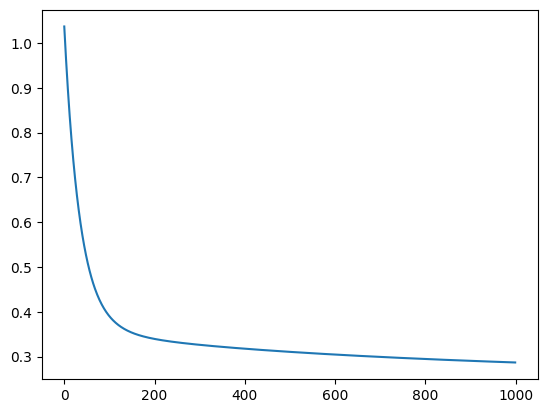

In [158]:
plt.plot(J_storage)

- Bar Graph of Beta Values for Environmental Variables 

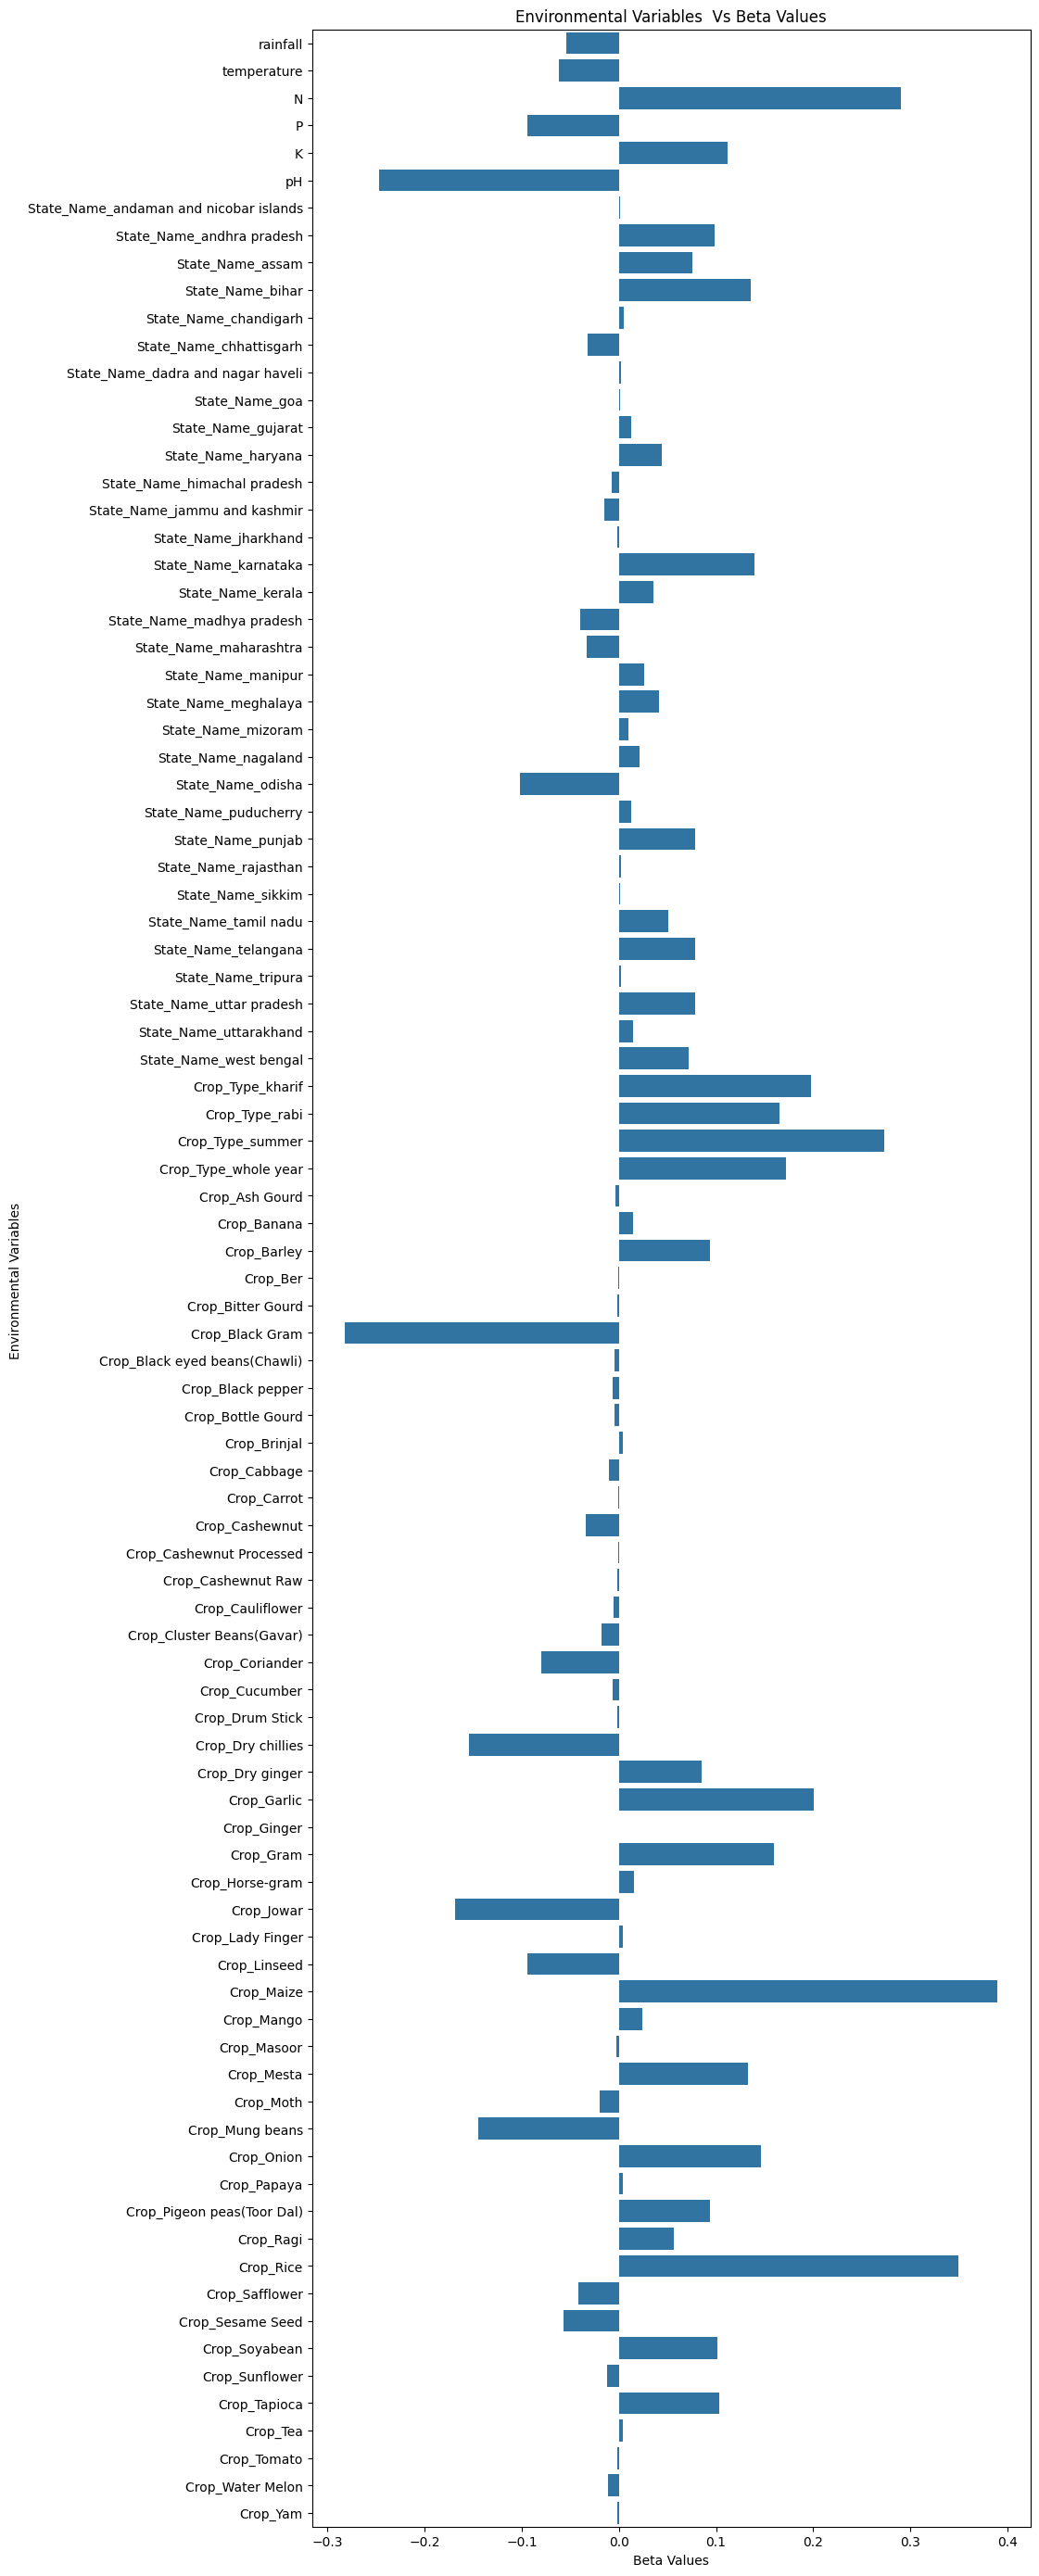

In [159]:
beta_data = beta_list[1:]
newBetaList = [item for sublist in beta_data for item in sublist]
# plt.barh(feature_title_list[39:43], newBetaList[39:43])
plt.figure(figsize=(10, 35))
sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
plt.xlabel('Beta Values')
plt.ylabel('Environmental Variables ')
plt.title('Environmental Variables  Vs Beta Values')
plt.show()

### Training Model 2

#### Pre-processing Data
I dropped states here as their weights seem to have minimal effect on the model in general

In [160]:
# # Read the CSV file
# df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoOutl.csv")
# df_CropYieldCombined_Model2 = df_CropYieldCombined.copy()

# #Drop columns
# df_CropYieldCombined_Model2 = df_CropYieldCombined_Model2.loc[:, ~df_CropYieldCombined_Model2.columns.str.startswith('State_Name')]
# df_CropYieldCombined_Model2.to_csv('Crop_Yield_Combined_Model2_NoOutl.csv', index=False)

#### Splitting and preparing 

In [164]:
# Read the CSV file
df_CropYieldCombined_Model2 = pd.read_csv("Crop_Yield_Combined_Model2_NoOutl.csv")

#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined_Model2.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined_Model2,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model2_means,model2_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)
print(X.shape)

(65354, 60)


#### Performing Gradient Descent on Model 2

In [165]:
#define model parameters
iterations = 1500
alpha = 0.01
beta = np.zeros((60,1))

#call gradient descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
#call predict() method
pred = predict_linreg(df_features_test, beta,model2_means,model2_stds,columns_to_normalize)
target = prepare_target(df_target_test)
mse = mean_squared_error(target, pred)
print(mse)

beta_list = beta.tolist()
data = {"beta": beta_list, "J_storage": J_storage}
with open('model1.json', 'w') as file:
    json.dump(data, file)

0.5631509505639967


#### Analysis and Visualization of Model 2

- Plotting Cost vs Iterations

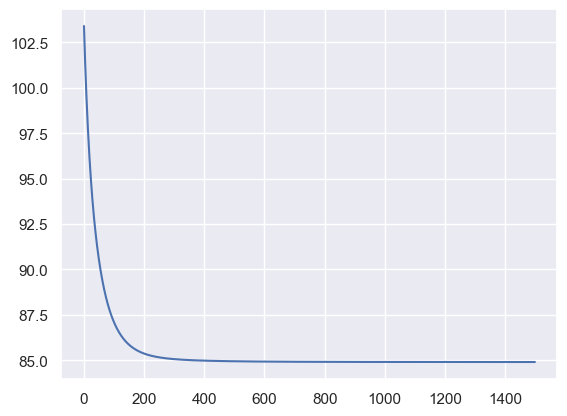

In [319]:
plt.plot(J_storage)

- Bar Graph of Beta Values for Environmental Variables 

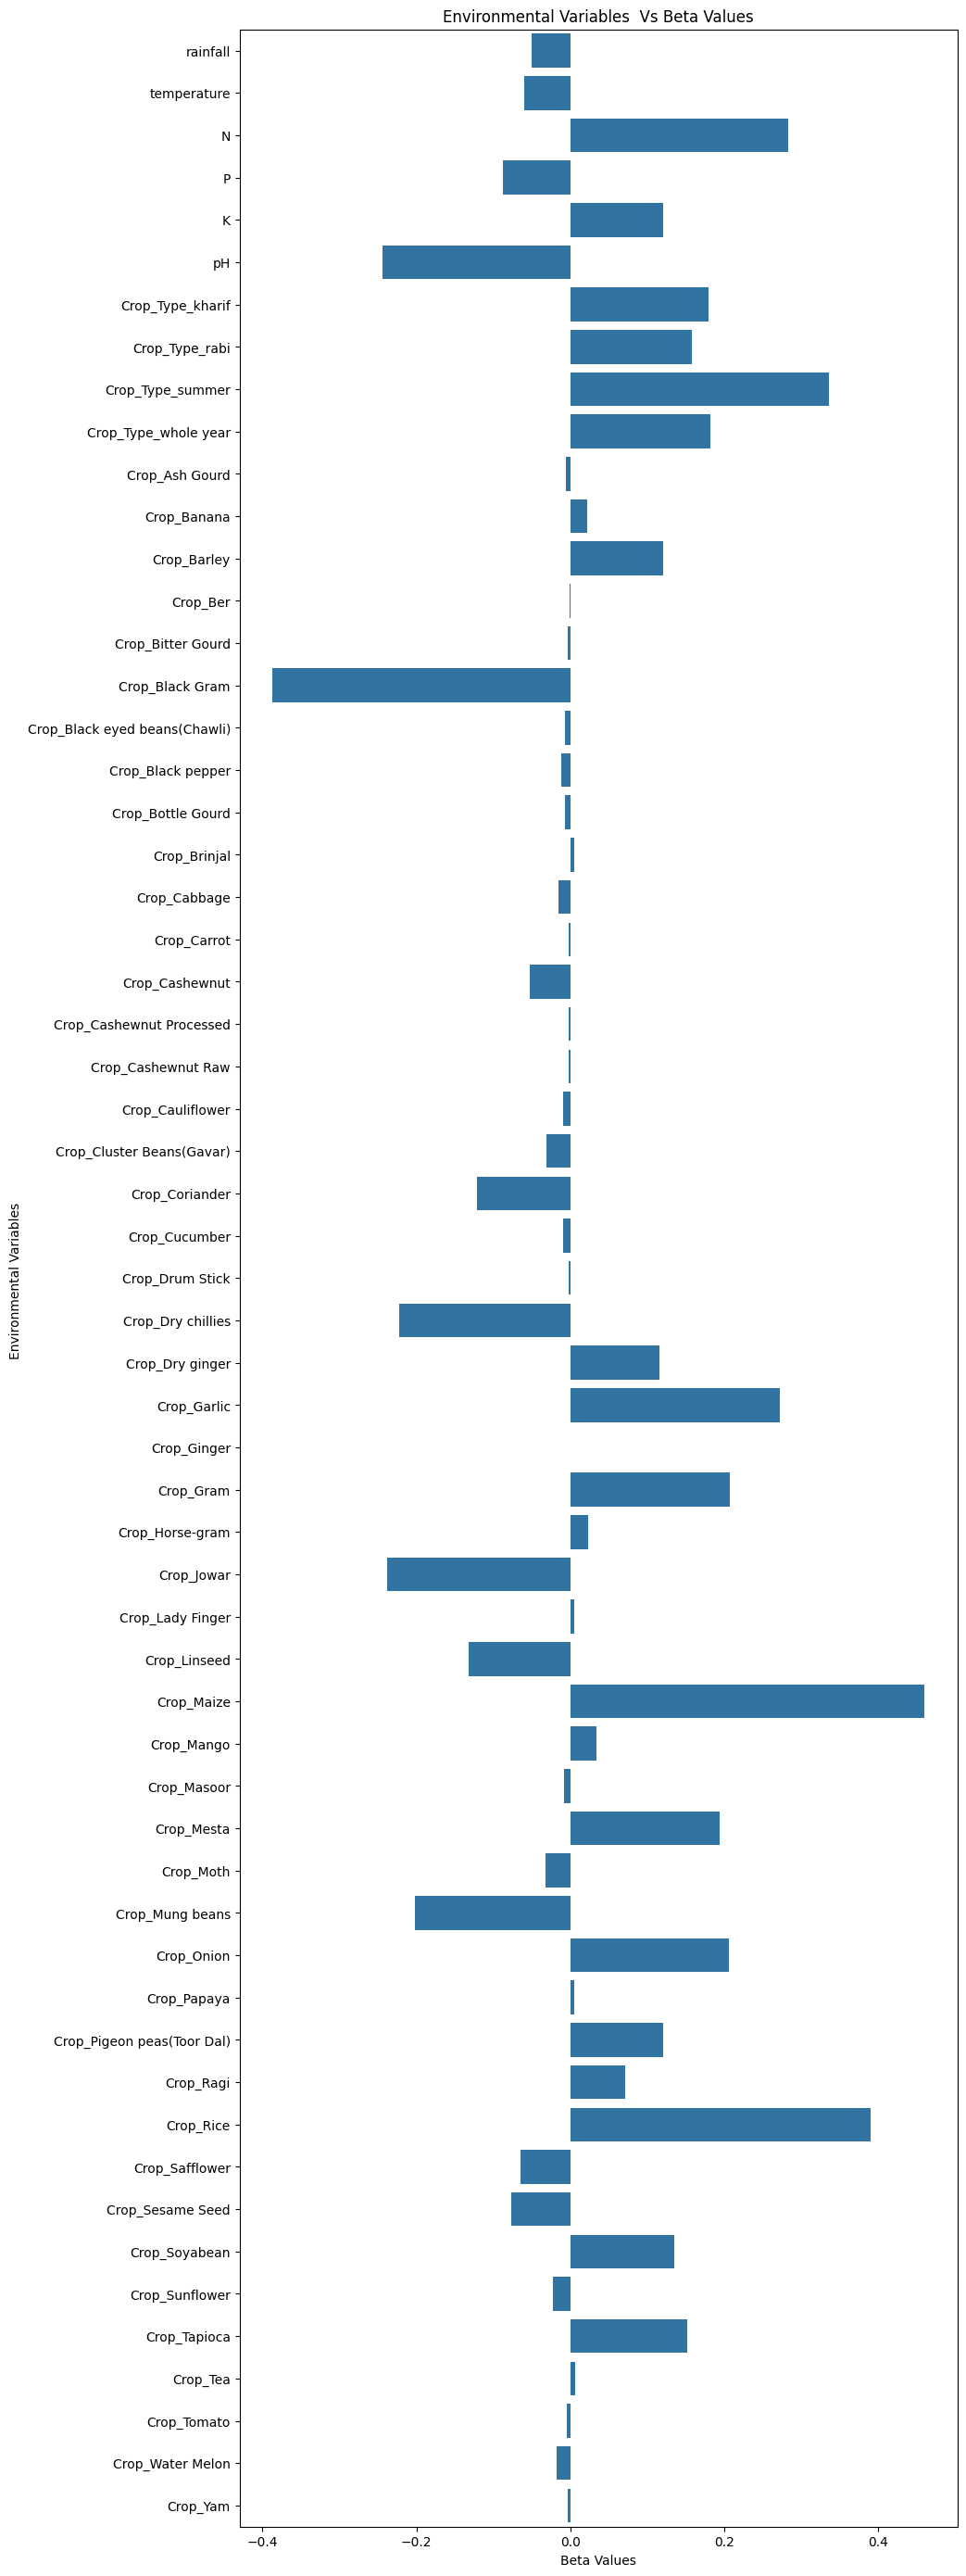

In [166]:
beta_data = beta_list[1:]
newBetaList = [item for sublist in beta_data for item in sublist]
# plt.barh(feature_title_list[39:43], newBetaList[39:43])
plt.figure(figsize=(10, 35))
sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
plt.xlabel('Beta Values')
plt.ylabel('Environmental Variables ')
plt.title('Environmental Variables  Vs Beta Values')
plt.show()

### Training Model 3

#### Pre-processing Data
I'm gonna try to insert similar number of crops

In [49]:
# Read the CSV file
df_CropYieldCombined = pd.read_csv("Crop_Yield_Combined_NoDummy_NoOutl.csv")
df_CropYieldCombined_Model3 = df_CropYieldCombined.copy()
crop_counts = df_CropYieldCombined_Model3['State_Name'].value_counts()
print(crop_counts)
# plt.figure(figsize=(10, 30))  # Adjust the figure size if needed
# crop_counts.plot(kind='barh')

# # Customize the plot
# plt.title('Crop Counts')
# plt.xlabel('Crop')
# plt.ylabel('Count')  # Rotate x-axis labels for better readability

# # Show the plot
# plt.show()

crops_to_drop = crop_counts[crop_counts < 1714].index

df_CropYieldCombined_Model3 = df_CropYieldCombined_Model3[df_CropYieldCombined_Model3["State_Name"].isin(crops_to_drop) == False]
display(df_CropYieldCombined_Model3)
# Define a function to sample rows within each group
def sample_rows(group):
    if len(group) >= 1714:
        return group.sample(1714)
    else:
        return group
# Use groupby and apply the function to sample rows for each group
df_CropYieldCombined_Model3 = df_CropYieldCombined_Model3.groupby("State_Name", group_keys=False, sort=False).apply(sample_rows)
crop_counts = df_CropYieldCombined_Model3['State_Name'].value_counts()
print(crop_counts)
crop_counts = df_CropYieldCombined_Model3['Crop'].value_counts()
print(crop_counts)
df_CropYieldCombined_Model3.drop(['Area_in_hectares', 'Production_in_tons'], axis=1, inplace=True)
#convert categories to dummy variables
df_CropYieldCombined_Model3_NoCat = pd.get_dummies(df_CropYieldCombined_Model3,dtype=int)
#move y column to last
df_CropYieldCombined_Model3_NoCat["Yield_ton_per_hec"] = df_CropYieldCombined_Model3_NoCat.pop("Yield_ton_per_hec")
# df_CropYieldCombined_Model3_NoCat.to_csv('Crop_Yield_Combined_Model3_NoOutl_New.csv', index=False)



State_Name
uttar pradesh                  12570
madhya pradesh                  9439
karnataka                       8856
bihar                           8592
odisha                          6210
rajasthan                       6010
maharashtra                     4970
tamil nadu                      4796
assam                           4284
west bengal                     3949
andhra pradesh                  3709
chhattisgarh                    3636
telangana                       2686
gujarat                         2430
haryana                         1775
uttarakhand                     1714
nagaland                        1225
himachal pradesh                 964
punjab                           809
meghalaya                        795
jharkhand                        747
kerala                           690
jammu and kashmir                664
manipur                          431
mizoram                          416
tripura                          358
puducherry                 

,State_Name,Crop_Type,Crop,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec,N,P,K,pH
0,andhra pradesh,kharif,Pigeon peas(Toor Dal),654.34,29.266667,21400.0,2600.0,0.121495,20.0,60.0,20.0,5.34
1,andhra pradesh,kharif,Dry chillies,654.34,29.266667,3700.0,7100.0,1.918919,120.0,20.0,80.0,6.48
2,andhra pradesh,kharif,Horse-gram,654.34,29.266667,3300.0,1000.0,0.303030,20.0,60.0,20.0,6.08
3,andhra pradesh,kharif,Jowar,654.34,29.266667,10100.0,10200.0,1.009901,80.0,40.0,40.0,5.58
4,andhra pradesh,kharif,Maize,654.34,29.266667,2800.0,4900.0,1.750000,80.0,40.0,20.0,5.64
...,...,...,...,...,...,...,...,...,...,...,...,...
93357,west bengal,rabi,Black Gram,152.54,22.280000,531.0,267.0,0.502825,40.0,60.0,20.0,5.06
93358,west bengal,summer,Maize,182.50,29.200000,258.0,391.0,1.515504,80.0,40.0,20.0,5.44
93359,west bengal,summer,Rice,182.50,29.200000,105.0,281.0,2.676190,80.0,40.0,40.0,5.32
93360,west bengal,rabi,Rice,152.54,22.280000,152676.0,261435.0,1.712352,80.0,40.0,40.0,5.36


State_Name
andhra pradesh    1714
assam             1714
bihar             1714
gujarat           1714
haryana           1714
karnataka         1714
madhya pradesh    1714
maharashtra       1714
odisha            1714
rajasthan         1714
tamil nadu        1714
telangana         1714
uttar pradesh     1714
west bengal       1714
chhattisgarh      1714
uttarakhand       1714
Name: count, dtype: int64
Crop
Rice                        3043
Maize                       2429
Mung beans                  2090
Black Gram                  2074
Sesame Seed                 1965
Pigeon peas(Toor Dal)       1755
Jowar                       1698
Gram                        1616
Dry chillies                1336
Sunflower                   1089
Ragi                         983
Horse-gram                   949
Masoor                       875
Barley                       834
Linseed                      721
Soyabean                     608
Coriander                    587
Garlic                       

#### Splitting and preparing 

In [50]:
# Read the CSV file
df_CropYieldCombined_Model3 = pd.read_csv("Crop_Yield_Combined_Model3_NoOutl_New.csv")

#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined_Model3.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined_Model3,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'temperature', 'N', 'P', 'K', 'pH']
df_features_train_z,model3_means,model3_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)
print(X.shape)

(19197, 74)


#### Performing Gradient Descent on Model 3

In [51]:
#define model parameters
iterations = 2000
alpha = 0.02
beta = np.zeros((74,1))

#call gradient descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
#call predict() method
pred = predict_linreg(df_features_test, beta,model3_means,model3_stds,columns_to_normalize)
target = prepare_target(df_target_test)

# Combine arrays side by side
combined_array = np.hstack((target, pred))

# Convert to a list of dictionaries with titles
data_list = [{"y": float(val_y), "y_pred": float(val_y_pred)} for val_y, val_y_pred in combined_array]

# Export to JSON
json_data = json.dumps(data_list)

# Write JSON data to a file
with open('pred.json', 'w') as json_file:
    json_file.write(json_data)

print(target.shape)
mse = mean_squared_error(target, pred)
print(mse)

beta_list = beta.tolist()
data = {"beta": beta_list, "J_storage": J_storage}
with open('model3.json', 'w') as file:
    json.dump(data, file)

(8227, 1)
0.5155462997139554


#### Analysis and Visualization of Model 3

- Plotting Cost vs Iterations

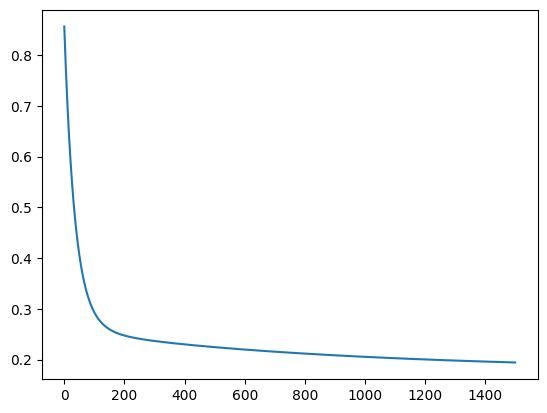

In [173]:
plt.plot(J_storage)

- Bar Graph of Beta Values for Environmental Variables 

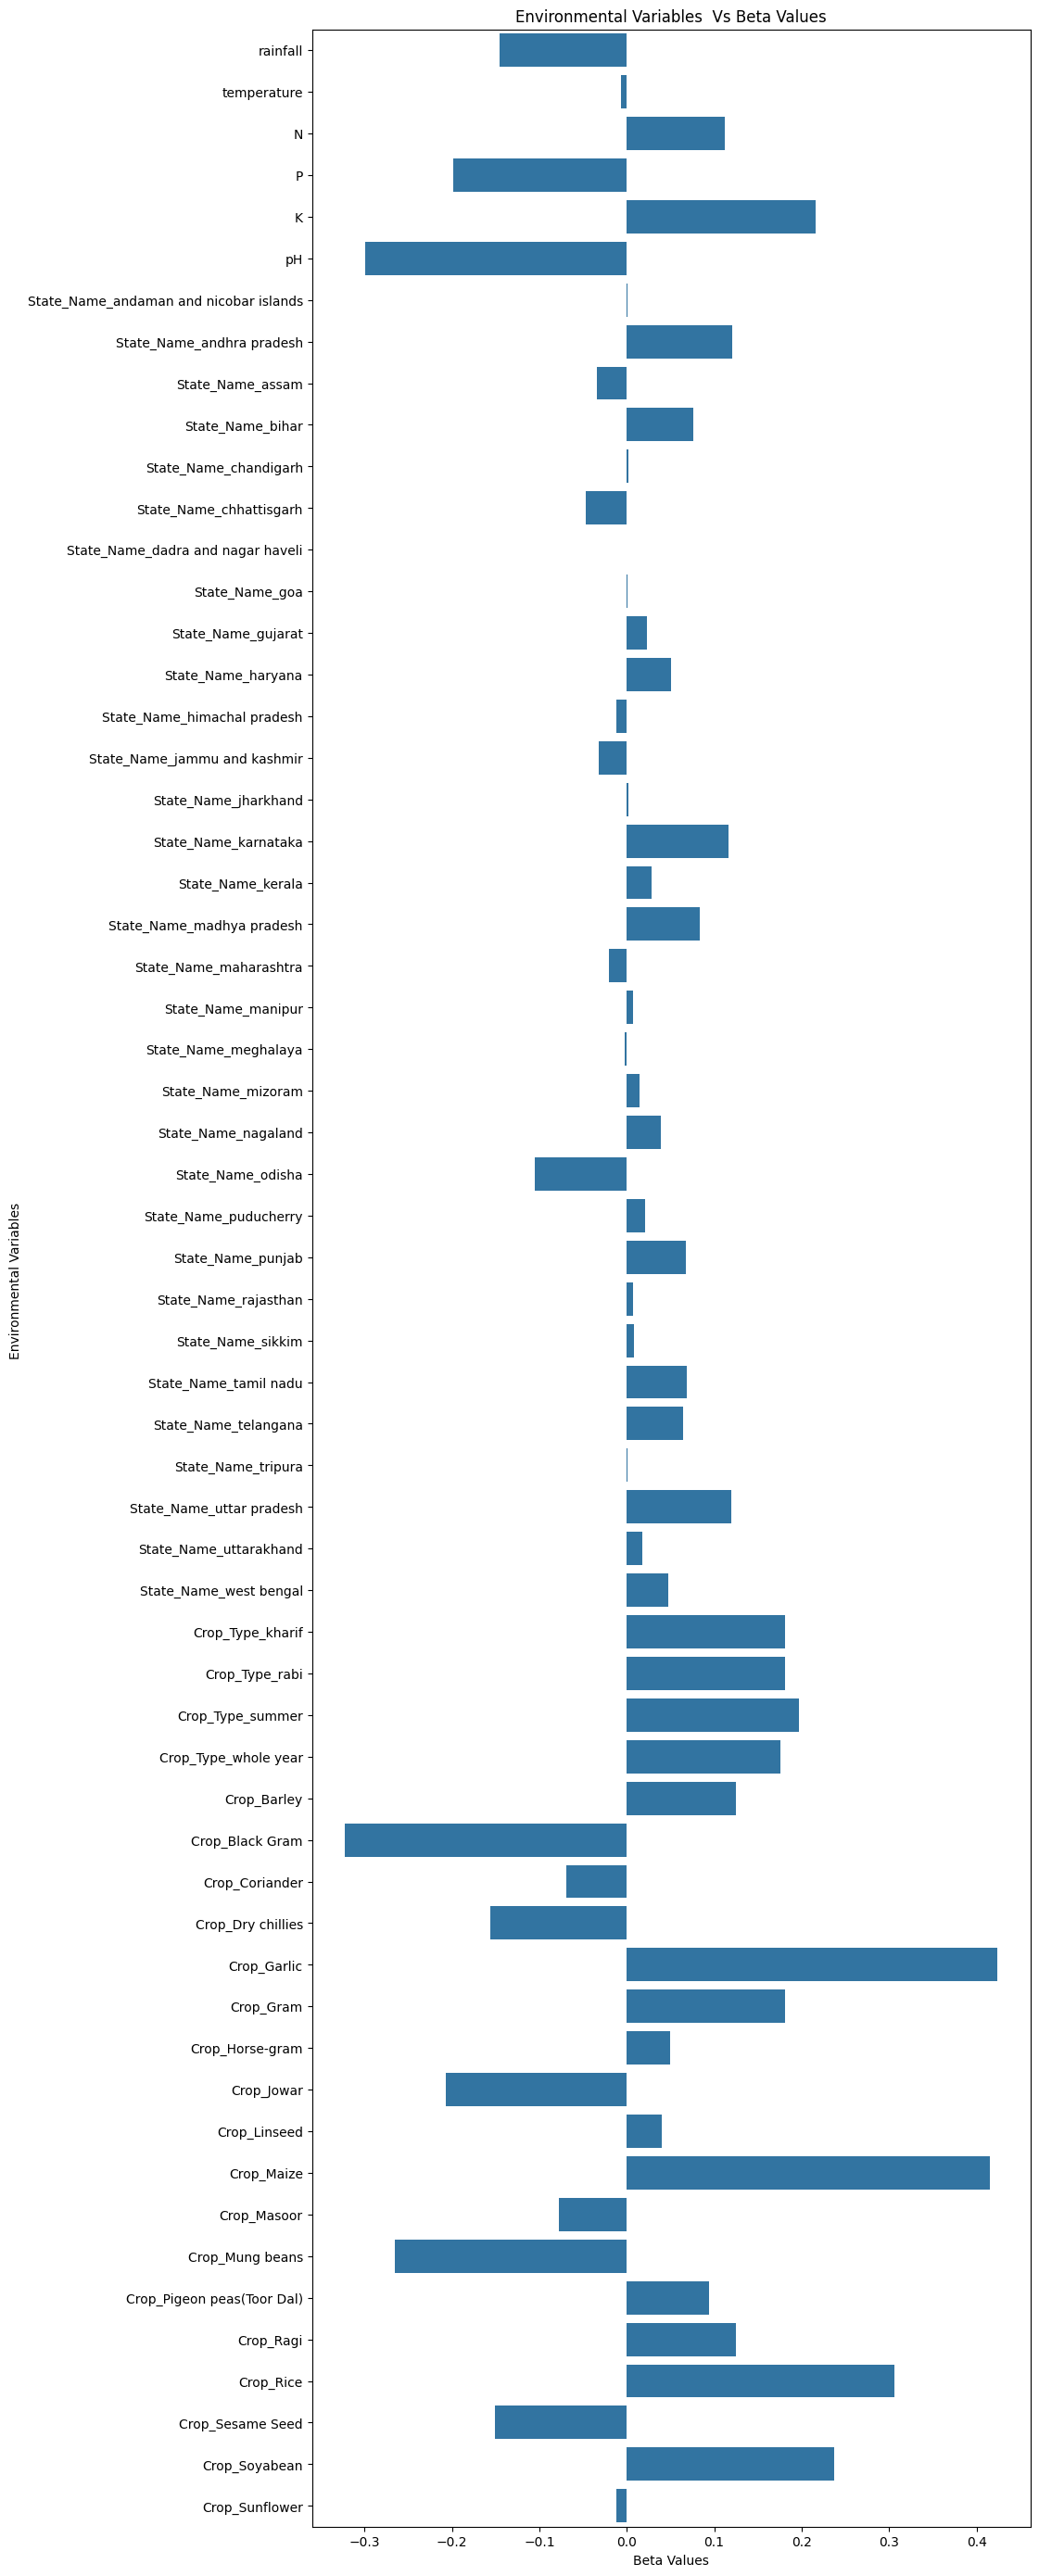

In [174]:
beta_data = beta_list[1:]
newBetaList = [item for sublist in beta_data for item in sublist]
# plt.barh(feature_title_list[39:43], newBetaList[39:43])
plt.figure(figsize=(10, 35))
sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
plt.xlabel('Beta Values')
plt.ylabel('Environmental Variables ')
plt.title('Environmental Variables  Vs Beta Values')
plt.show()

### Training Model 4

#### Pre-processing Data
Removing temperature column 

In [175]:
# Read the CSV file
df_CropYieldCombined_Model3 = pd.read_csv("Crop_Yield_Combined_Model3_NoOutl.csv")
df_CropYieldCombined_Model4 = df_CropYieldCombined_Model3.copy()
df_CropYieldCombined_Model4.drop(['temperature'],axis=1,inplace=True)

# df_CropYieldCombined_Model4.to_csv('Crop_Yield_Combined_Model4_NoOutl.csv', index=False)



#### Splitting and preparing 

In [28]:
# Read the CSV file
df_CropYieldCombined_Model4 = pd.read_csv("Crop_Yield_Combined_Model4_NoOutl.csv")
#Extract Feature Titles
feature_title_list  = [col for col in df_CropYieldCombined_Model4.columns if col != 'Yield_ton_per_hec']

# Extract the features and the targets 
df_features, df_target = get_features_targets(df_CropYieldCombined_Model4,feature_title_list,["Yield_ton_per_hec"])

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize using z normalization
columns_to_normalize = ['rainfall', 'N', 'P', 'K', 'pH']
df_features_train_z,model4_means,model4_stds= normalize_z(df_features_train,columns_to_normalize)

#prepare X and target to nummpy arrays 
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)
print(X.shape)

(22113, 60)


#### Performing Gradient Descent on Model 4

In [29]:
#define model parameters
iterations = 5000
alpha = 0.5
beta = np.zeros((60,1))

#call gradient descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
#call predict() method
pred = predict_linreg(df_features_test, beta,model4_means,model4_stds,columns_to_normalize)
target = prepare_target(df_target_test)

# Combine arrays side by side
combined_array = np.hstack((target, pred))

# Convert to a list of dictionaries with titles
data_list = [{"y": float(val_y), "y_pred": float(val_y_pred)} for val_y, val_y_pred in combined_array]

# Export to JSON
json_data = json.dumps(data_list)

# Write JSON data to a file
with open('pred1.json', 'w') as json_file:
    json_file.write(json_data)

print(target.shape)
mse = mean_squared_error(target, pred)
print(mse)

beta_list = beta.tolist()
model4_means_list = model4_means.tolist()
model4_stds_list = model4_stds.tolist()
data = {"beta": beta_list, "J_storage": J_storage,"means":model4_means_list, "stds":model4_stds_list}
data = {
    "beta": beta_list,
    "J_storage": J_storage,
    "means": {"columns": model4_means.index.tolist(), "values": model4_means_list},
    "stds": {"columns": model4_stds.index.tolist(), "values": model4_stds_list}
}
with open('model4(best).json', 'w') as file:
    json.dump(data, file)

(9477, 1)
0.3464389484286626


#### Analysis and Visualization of Model 4

- Plotting Cost vs Iterations

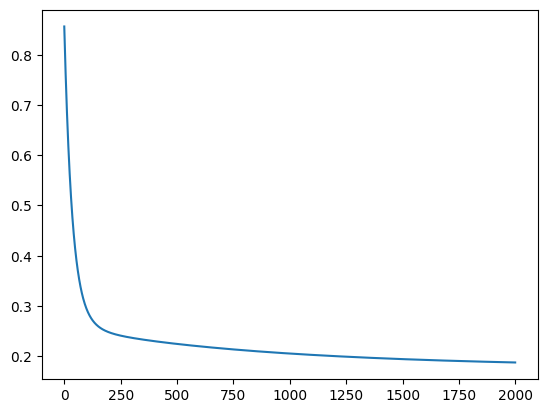

In [193]:
plt.plot(J_storage)

- Bar Graph of Beta Values for Environmental Variables 

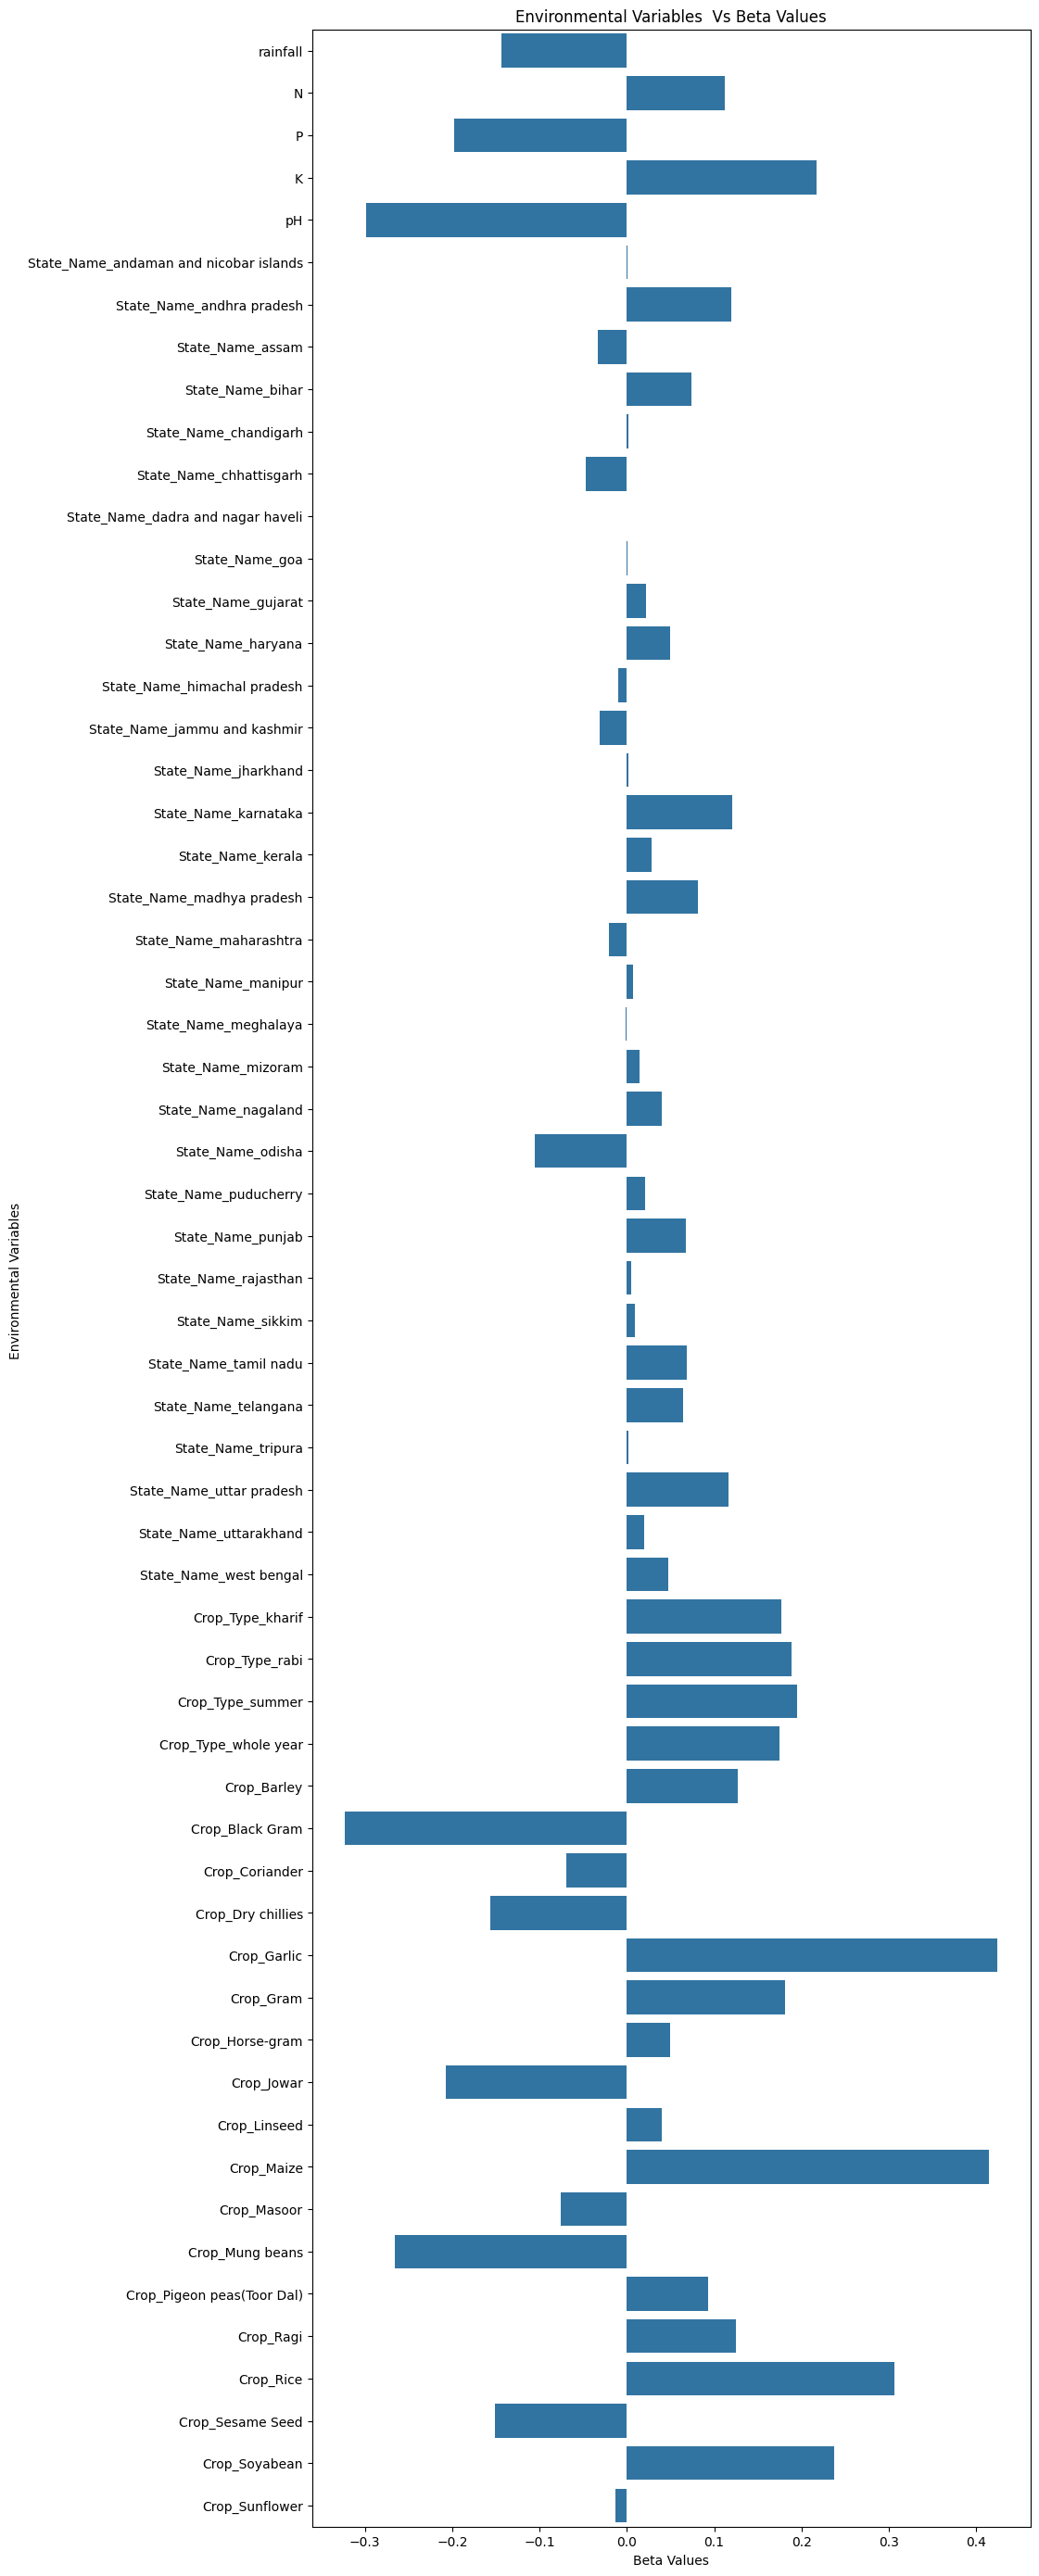

In [180]:
beta_data = beta_list[1:]
newBetaList = [item for sublist in beta_data for item in sublist]
# plt.barh(feature_title_list[39:43], newBetaList[39:43])
plt.figure(figsize=(10, 35))
sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
plt.xlabel('Beta Values')
plt.ylabel('Environmental Variables ')
plt.title('Environmental Variables  Vs Beta Values')
plt.show()

### Prediction Function

In [42]:
#---------------------Functions start---------------------
#To get Crop Type
def enterCropTye(user_inp_dict,month_inp):
    crop_types = ['Crop_Type_kharif', 'Crop_Type_rabi', 'Crop_Type_summer', 'Crop_Type_whole year']
    if month_inp in [3,4,5]:
        user_inp_dict['Crop_Type_kharif'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    elif month_inp in [12,1,2]:
        user_inp_dict['Crop_Type_rabi'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    elif month_inp in [6,7,8]:
        user_inp_dict['Crop_Type_summer'] = 1
        user_inp_dict['Crop_Type_whole year'] = 1
    else:
        user_inp_dict['Crop_Type_whole year'] = 1

#To get valid state
def get_valid_state_input(statesList):
    while True:
        # User input state
        user_input_state = input("Enter state name(in India): ")

        # Find the best match and score
        matchResult = process.extractOne(user_input_state, statesList)

        # Check if the score is greater than 85
        if matchResult[1] > 85:
            return "State_Name_" + matchResult[0]
        else:
            print(f"Invalid input. Please try again with a valid state.")
#Print inputs 
def print_result_statements(rainfall, N, P, K, pH, state, month):
    print(f"\nResult Statements:")
    print(f"Rainfall Conditions: {rainfall}")
    print(f"N Conditions: {N}")
    print(f"P Conditions: {P}")
    print(f"K Conditions: {K}")
    print(f"pH Conditions: {pH}")
    print(f"State: {state}")
    print(f"Month: {month}")

#-----------------functions end---------------------


#Load Data Used for best model
df_Model4_Data = pd.read_csv('Crop_Yield_Combined_Model4_NoOutl.csv')
#extract feature names 
featureColumnNames = df_Model4_Data.columns[:-1]
#create new Datafram with just features;ready to input prediction data
df_Model4_ToUse = pd.DataFrame(columns=featureColumnNames)
statesList = df_Model4_ToUse.columns[df_Model4_ToUse.columns.str.startswith('State_Name')].tolist()
statesList = [col.replace('State_Name_', '') for col in statesList]
print(statesList)
#start getting inputs to predict
# rainfall_inp = float(input('Enter rainfall conditions:')) 
# N_inp = float(input('Enter N conditions:'))
# P_inp = float(input('Enter P conditions:'))
# K_inp = float(input('Enter K conditions:'))
# pH_inp = float(input('Enter pH conditions:'))
# state_inp = get_valid_state_input(statesList)
# month_inp = float((input('Enter month:')))
# print_result_statements(rainfall_inp, N_inp, P_inp, K_inp, pH_inp, state_inp, month_inp)

# # create dictionary containing user inputs
# user_inp_dict = {}
# user_inp_dict['rainfall'] = rainfall_inp
# user_inp_dict['N'] = N_inp
# user_inp_dict['P'] = P_inp
# user_inp_dict['K'] = K_inp
# user_inp_dict['pH'] = pH_inp
# user_inp_dict[state_inp] = 1
#test vals
month_inp = 9
user_inp_dict = {}
user_inp_dict['rainfall'] = float(384)
user_inp_dict['N'] = float(40)
user_inp_dict['P'] = float(60)
user_inp_dict['K'] = float(100)
user_inp_dict['pH'] = float(5.34)
user_inp_dict["State_Name_chandigarh"] = 1

#enter crop_type(which season crop) based on month
enterCropTye(user_inp_dict,month_inp)

#Enter user inputs into df_Model4_ToUse
user_inp_df = pd.DataFrame([user_inp_dict])
df_Model4_ToUse = pd.concat([df_Model4_ToUse,user_inp_df],ignore_index=True)
#Enter use inputs to predict yield for each crop
crop_columns = [col for col in df_Model4_ToUse.columns if col.startswith('Crop_') and not col.startswith('Crop_Type')]

initial_input_row = df_Model4_ToUse.iloc[0]
#add rows corresponding to number of crops
df_Model4_ToUse = pd.concat([df_Model4_ToUse]* (len(crop_columns)),ignore_index=True)
for index in range(len(crop_columns)):
    df_Model4_ToUse.at[index,crop_columns[index]] = 1
df_Model4_ToUse.fillna(0,inplace=True)
# Loading beta values from json file
bestModelWeightsJson = open('model3(best).json')
bestModelWeights = json.load(bestModelWeightsJson)
beta_values = bestModelWeights['beta']
# Convert lists back to pandas Series
means_columns = bestModelWeights['means']['columns']
means_values = bestModelWeights['means']['values']
model4_means = pd.Series(means_values, index=means_columns)
# Convert lists back to pandas Series
stds_columns = bestModelWeights['stds']['columns']
stds_values = bestModelWeights['stds']['values']
model4_stds = pd.Series(stds_values, index=stds_columns)
columns_to_normalize = ['rainfall', 'N', 'P', 'K', 'pH']
#initiate predicting
pred = predict_linreg(df_Model4_ToUse, beta_values,model4_means,model4_stds,columns_to_normalize)
print(pred)
highest_y_index = np.argmax(pred)
predicted_crop = crop_columns[highest_y_index]
print(predicted_crop)


['andaman and nicobar islands', 'andhra pradesh', 'assam', 'bihar', 'chandigarh', 'chhattisgarh', 'dadra and nagar haveli', 'goa', 'gujarat', 'haryana', 'himachal pradesh', 'jammu and kashmir', 'jharkhand', 'karnataka', 'kerala', 'madhya pradesh', 'maharashtra', 'manipur', 'meghalaya', 'mizoram', 'nagaland', 'odisha', 'puducherry', 'punjab', 'rajasthan', 'sikkim', 'tamil nadu', 'telangana', 'tripura', 'uttar pradesh', 'uttarakhand', 'west bengal']
[[2.354592562323603]
 [1.7155173169055402]
 [1.712568700464081]
 [1.318244326748524]
 [3.0118342466744465]
 [2.0308205788300207]
 [1.744583994921383]
 [1.7197109960130683]
 [1.7203923638885026]
 [2.8989526820217963]
 [1.8859337781452572]
 [1.50159323007436]
 [2.1008530825355063]
 [2.3032363774775897]
 [2.5951763246943247]
 [1.2336119407054968]
 [2.3981173905622626]
 [1.9278678130627305]]
Crop_Garlic


/var/folders/k5/kwnm67cj11j95x28sdwr66dw0000gn/T/ipykernel_66240/4033434578.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_Model4_ToUse = pd.concat([df_Model4_ToUse,user_inp_df],ignore_index=True)


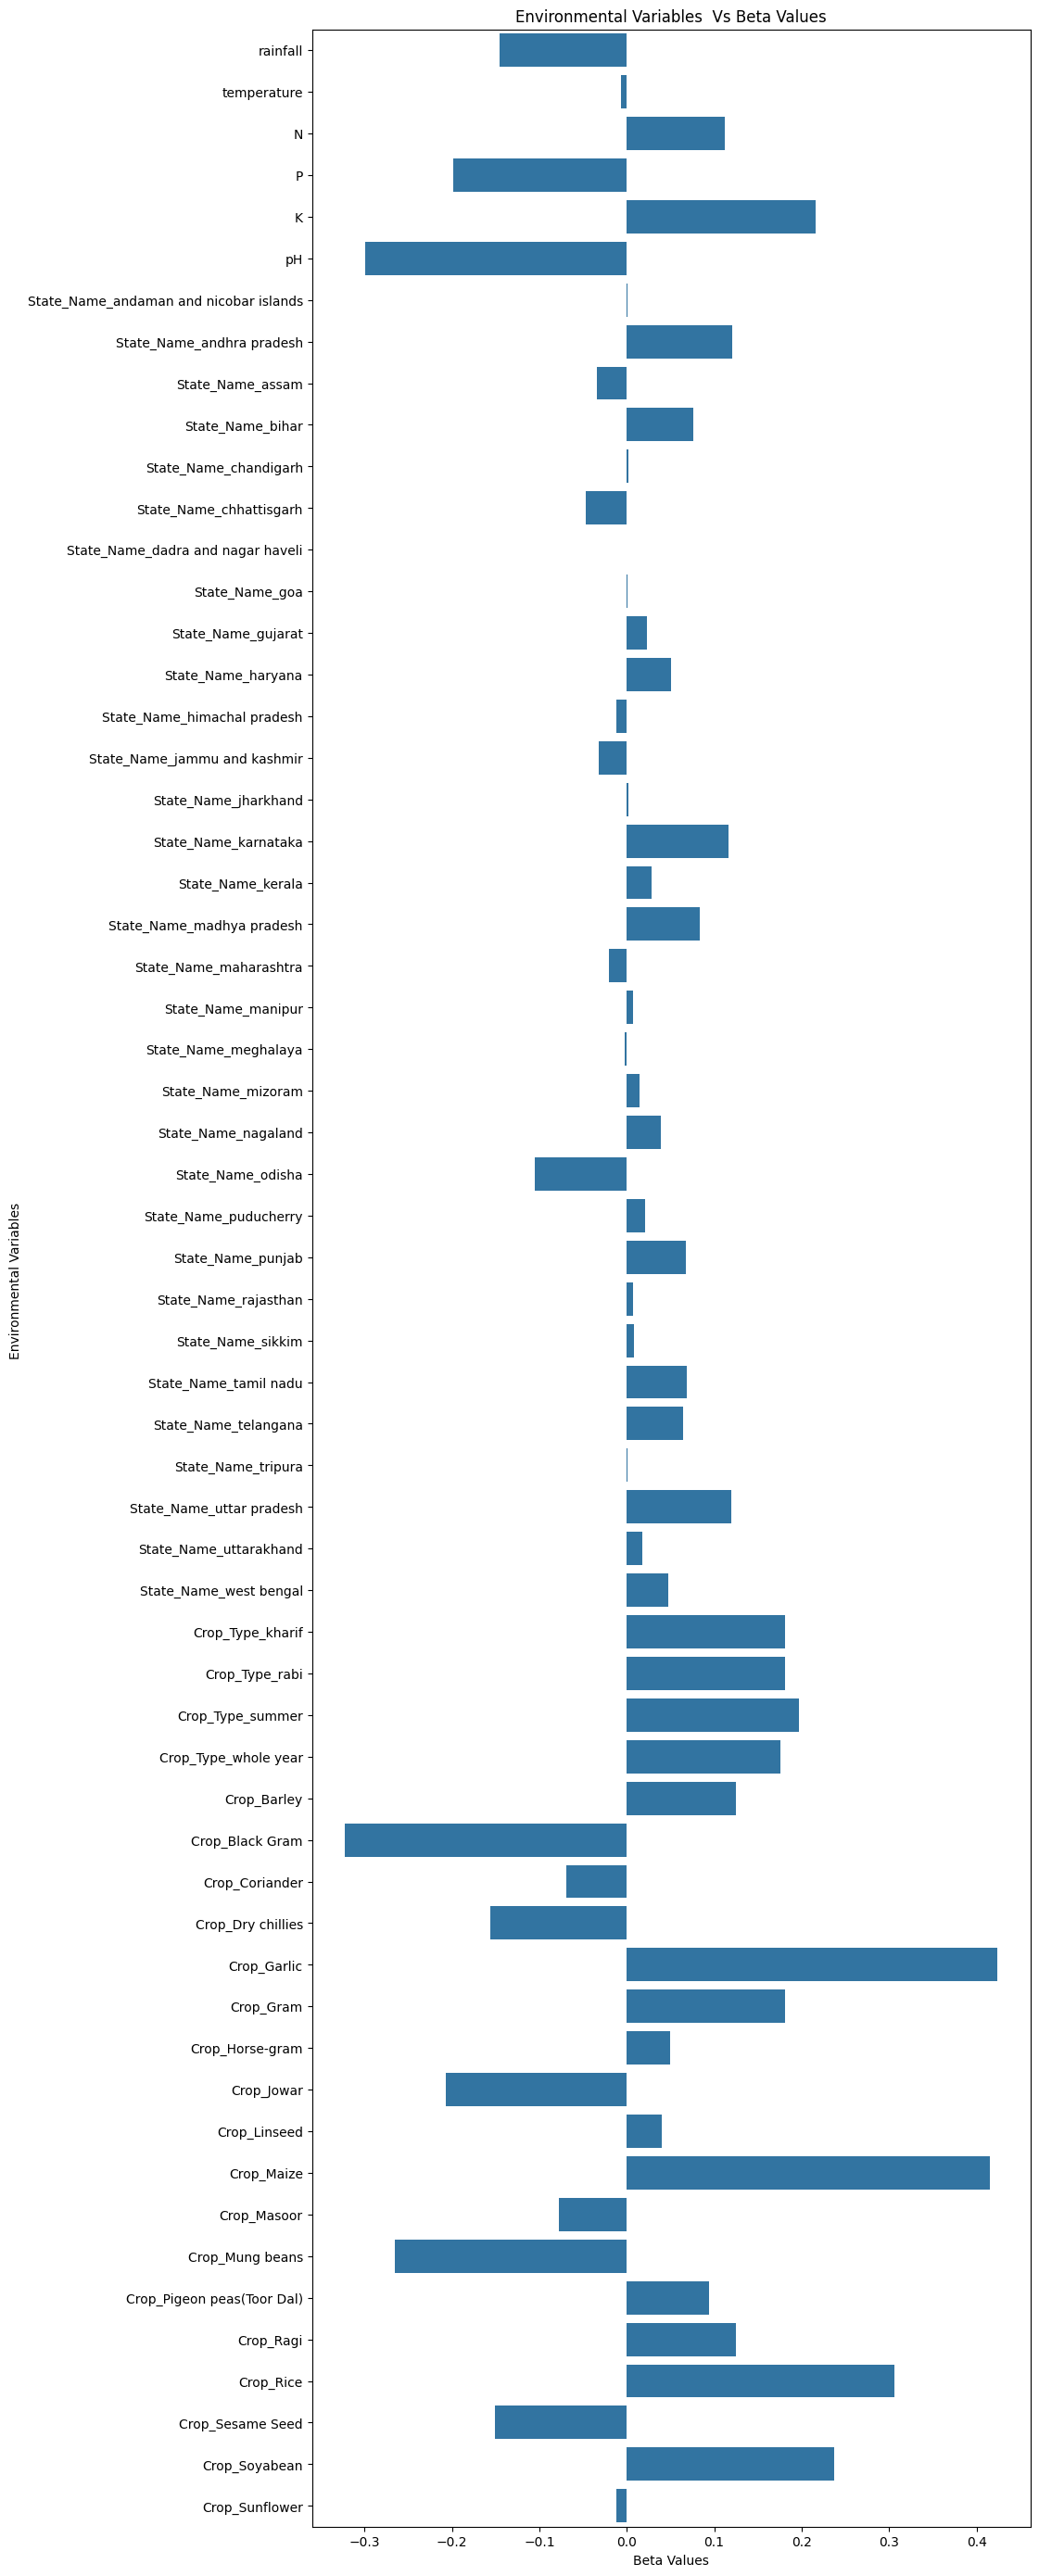

In [ ]:
beta_data = beta_list[1:]
newBetaList = [item for sublist in beta_data for item in sublist]
# plt.barh(feature_title_list[39:43], newBetaList[39:43])
plt.figure(figsize=(10, 35))
sns.barplot(x=newBetaList[0:110], y=feature_title_list[0:110])
plt.xlabel('Beta Values')
plt.ylabel('Environmental Variables ')
plt.title('Environmental Variables  Vs Beta Values')
plt.show()